In [1]:
import sys
import os
import random
import csv
from pprint import pprint
from typing import Dict, List, Tuple

import matplotlib as mplt
from matplotlib import pyplot as plt

module_path = os.path.abspath(os.path.join("..", ".."))
sys.path.append(module_path)

from perceptron.model import Model, cross_validation
from perceptron.layer import Layer
from perceptron.activation import (
    Heavyside,
    Linear,
    Relu,
    LeakyRelu,
    Sigmoid,
    Tanh,
    Softmax,
)
from perceptron.data_util import transpose, to_binary


In [2]:
with open("sonar.csv", "rt") as f:
    data = [
        [float(value) for value in features] + [target]
        for *features, target in [line for line in csv.reader(f) if line]
    ]

*features, targets = transpose(data)
features = transpose(features)
mapping, targets = to_binary(targets)

print("Labels mapping:")
for label in mapping:
    print(label, mapping[label])


Labels mapping:
M 0
R 1


# Helper function
Prints result of a comparisson, expects dictionary of training histories

In [3]:
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("svg")

Name = str
History = Dict[str, List]


def plot(histories: Dict[Name, History], figsize: Tuple[int] = (10, 4)):

    metrics = set()
    for name in histories:
        metrics.update(histories[name].keys())

    fig = plt.figure(figsize=figsize)
    gs = mplt.gridspec.GridSpec(1, len(metrics))

    for subplot_index, metric in enumerate(sorted(metrics)):
        ax = fig.add_subplot(gs[subplot_index])

        min_ = None
        max_ = None

        for name in histories:
            history = histories[name][metric]
            ax.plot(range(epochs + 1), history, label=name)

            min_ = min(history) if min_ is None else min(min_, min(history))
            max_ = max(history) if max_ is None else max(max_, max(history))

        scale = abs(max_ - min_) * 0.1

        ax.set_ylim(
            bottom=min_ + scale if min_ < 0 else min_ - scale,
            top=max_ - scale if max_ < 0 else max_ + scale,
        )
        ax.grid()
        ax.legend()
        ax.set_title(metric)

    plt.show()


# Single layer model

Training: 100% |████████████████████████████████████████| 500/500, binary_accuracy=0.995


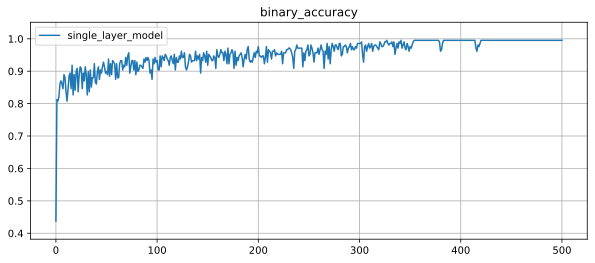

In [4]:
random.seed(0)


def model_factory():
    input_size = 60
    layer_init_method = "he"

    model = Model(normalizer="zscore")

    model.add(Layer(input_size, layer_size=1, init_method=layer_init_method))
    model.add(Sigmoid())

    return model


optimizer = "adam"
model = model_factory()
model.compile(optimizer)

metrics = ["binary_accuracy"]
epochs = 500
history = model.train(
    training_inputs=features,
    training_targets=targets,
    epochs=epochs,
    loss_function="binary_crossentropy",
    batch_size=2,
    base_learning_rate=0.2,
    learning_rate_decay="linear",
    metrics=metrics,
)


plot({"single_layer_model": history})


# Multi-layer model

Training: 100% |████████████████████████████████████████| 50/50, binary_accuracy=1    


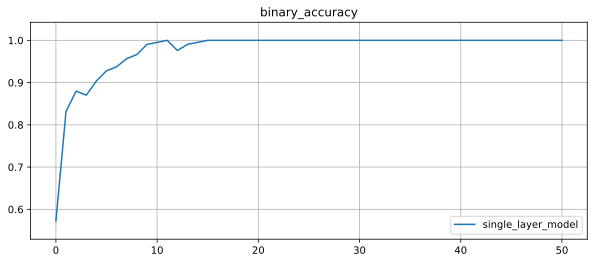

In [5]:
random.seed(0)


def model_factory():
    input_size = 60
    layer_init_method = "he"

    model = Model(normalizer="zscore")

    model.add(Layer(input_size, layer_size=5, init_method=layer_init_method))
    model.add(LeakyRelu())
    model.add(Layer(input_size=5, layer_size=5, init_method=layer_init_method))
    model.add(LeakyRelu())
    model.add(Layer(input_size=5, layer_size=1, init_method=layer_init_method))
    model.add(Sigmoid())

    return model


optimizer = "adam"
model = model_factory()
model.compile(optimizer)

metrics = ["binary_accuracy"]
epochs = 50
loss_function = "binary_crossentropy"
batch_size = 2
base_learning_rate = 0.01
learning_rate_decay = "linear"

history = model.train(
    training_inputs=features,
    training_targets=targets,
    epochs=epochs,
    loss_function="binary_crossentropy",
    batch_size=2,
    base_learning_rate=0.01,
    learning_rate_decay="linear",
    metrics=metrics,
)


plot({"single_layer_model": history})


# Cross validating multi-layer model

Training: 100% |████████████████████████████████████████| 50/50, binary_accuracy=1, val_binary_accuracy=0.786    
Training: 100% |████████████████████████████████████████| 50/50, binary_accuracy=1, val_binary_accuracy=0.739   
Training: 100% |████████████████████████████████████████| 50/50, binary_accuracy=1, val_binary_accuracy=0.841    


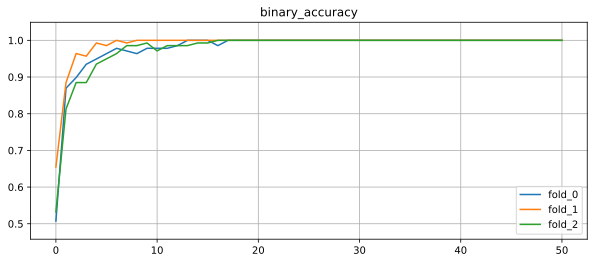

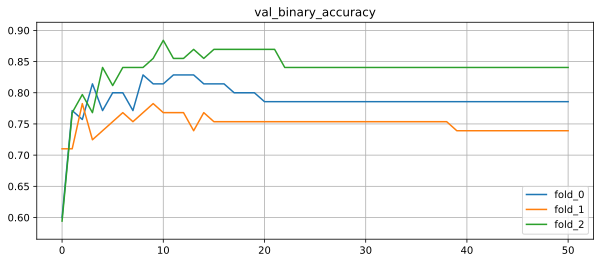

In [6]:
random.seed(0)

history = cross_validation(
    model_factory=model_factory, 
    inputs=features,
    targets=targets,
    fold_count=3, 
    optimizer=optimizer, 
    epochs=epochs,
    loss_function=loss_function,
    batch_size=batch_size,
    base_learning_rate=base_learning_rate,
    learning_rate_decay=learning_rate_decay,
    metrics=metrics
)


train_histories = {}
val_histories = {}
for fold_index, fold in enumerate(history):
    name = f"fold_{fold_index}"
    train_histories[name] = {}
    val_histories[name] = {}

    for metric in metrics:
        if not isinstance(metric, str):
            metric = metric.name
        val_histories[name]["val_" + metric] = fold["val_" + metric]
        train_histories[name][metric] = fold[metric]

plot(train_histories, figsize=(10, 4))
plot(val_histories, figsize=(10, 4))
